In [12]:
import lib ## my module set

import os
import torch
import torchvision
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import random

from tqdm import tqdm
from sklearn.manifold import TSNE
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.models import efficientnet_b0, mobilenet_v2, efficientnet_b2
from sklearn.metrics import silhouette_score, silhouette_samples



%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # 멀티 GPU를 사용하는 경우
np.random.seed(42)
random.seed(42)
# torch.backends.cudnn.deterministic = True ## 속도가 느려질 수 있음
# torch.backends.cudnn.benchmark = False

plt.rcParams['font.family'] = 'Liberation Serif'

In [13]:
train = pd.read_csv("./train_v2.csv")
valid = pd.read_csv("./valid_v2.csv")
test = pd.read_csv("./test_v2.csv")

In [14]:
train_dataset = lib.CustomDataset(train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8) 

valid_dataset = lib.CustomDataset(valid, train_test= False)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8)

test_dataset = lib.CustomDataset(test, train_test = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory= True, num_workers = 8)

In [18]:
class MyNeural(nn.Module):
    def __init__(self, model, freeze_ratio = 0.7):
        super(MyNeural, self).__init__()

        self.mother = lib.freeze_layers_by_percentage(model,freeze_ratio)

        self.mother.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace = True),
        nn.Linear(in_features = 1408, out_features = 256, bias = True),
        )
        
        self.classifier = nn.Sequential(
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = True),
            nn.Linear(256, 64, bias = True),
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = True),
            nn.Linear(64, 4, bias = True)
        )

    
    def forward(self, x):
        embedding = self.mother(x)
         
        x = self.classifier(embedding)

        return (embedding, x)

Efficient_b0 = efficientnet_b2(weights = 'IMAGENET1K_V1')

Efficient_b0 = MyNeural(Efficient_b0, freeze_ratio = 0.0).to(device)

Features 블록 총 9개 중 0개 고정
고정할 블록들: []
훈련가능: features.0.0.weight
훈련가능: features.0.1.weight
훈련가능: features.0.1.bias
훈련가능: features.1.0.block.0.0.weight
훈련가능: features.1.0.block.0.1.weight
훈련가능: features.1.0.block.0.1.bias
훈련가능: features.1.0.block.1.fc1.weight
훈련가능: features.1.0.block.1.fc1.bias
훈련가능: features.1.0.block.1.fc2.weight
훈련가능: features.1.0.block.1.fc2.bias
훈련가능: features.1.0.block.2.0.weight
훈련가능: features.1.0.block.2.1.weight
훈련가능: features.1.0.block.2.1.bias
훈련가능: features.1.1.block.0.0.weight
훈련가능: features.1.1.block.0.1.weight
훈련가능: features.1.1.block.0.1.bias
훈련가능: features.1.1.block.1.fc1.weight
훈련가능: features.1.1.block.1.fc1.bias
훈련가능: features.1.1.block.1.fc2.weight
훈련가능: features.1.1.block.1.fc2.bias
훈련가능: features.1.1.block.2.0.weight
훈련가능: features.1.1.block.2.1.weight
훈련가능: features.1.1.block.2.1.bias
훈련가능: features.2.0.block.0.0.weight
훈련가능: features.2.0.block.0.1.weight
훈련가능: features.2.0.block.0.1.bias
훈련가능: features.2.0.block.1.0.weight
훈련가능: features.2.0.block.

In [19]:
## 학습을 위한 최적화, 함수, Miner 설정

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(Efficient_b0.parameters(), lr=1e-4)

# training, Deep Metric Learning

patience = 0
Epochs = 100
best_loss = 999999.0

for epoch in range(Epochs):
    train_loss, train_correct = lib.classifier_train(train_loader, Efficient_b0, loss_fn, optimizer)
    valid_loss, valid_correct = lib.classifier_validation(valid_loader, Efficient_b0, loss_fn)
    
    print(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Train Correct: {train_correct} Valid Loss = {valid_loss:.4f}, Valid Correct = {valid_correct}")
    
    if best_loss > valid_loss:
        best_loss = valid_loss
        patience = 0
        print(f'Epoch {epoch} Model saved ')
        torch.save({
                'model' : Efficient_b0.state_dict(),
                'optimizer' : optimizer.state_dict()}, '../model_weight/Classifier/Efficientb2.pth')
    else:
        patience += 1
        if patience == 10:
            print('early stopping')
            break
        

Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 0 : Train Loss = 1.2943, Train Correct: 0.4919011082693947 Valid Loss = 0.9847, Valid Correct = 0.6130952380952381
Epoch 0 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.79it/s]


Epoch 1 : Train Loss = 0.8888, Train Correct: 0.6606990622335891 Valid Loss = 0.7569, Valid Correct = 0.6815476190476191
Epoch 1 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.66it/s]


Epoch 2 : Train Loss = 0.7218, Train Correct: 0.7050298380221653 Valid Loss = 0.6972, Valid Correct = 0.7232142857142857
Epoch 2 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.42it/s]


Epoch 3 : Train Loss = 0.6213, Train Correct: 0.7433930093776641 Valid Loss = 0.6032, Valid Correct = 0.7410714285714286
Epoch 3 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.75it/s]


Epoch 4 : Train Loss = 0.5492, Train Correct: 0.7544757033248082 Valid Loss = 0.5360, Valid Correct = 0.7589285714285714
Epoch 4 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.41it/s]


Epoch 5 : Train Loss = 0.4899, Train Correct: 0.7919863597612958 Valid Loss = 0.4750, Valid Correct = 0.7857142857142857
Epoch 5 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


Epoch 6 : Train Loss = 0.4187, Train Correct: 0.8252344416027281 Valid Loss = 0.5163, Valid Correct = 0.7678571428571429


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.88it/s]


Epoch 7 : Train Loss = 0.3591, Train Correct: 0.8644501278772379 Valid Loss = 0.4144, Valid Correct = 0.8154761904761905
Epoch 7 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.89it/s]


Epoch 8 : Train Loss = 0.3425, Train Correct: 0.8525149190110827 Valid Loss = 0.3964, Valid Correct = 0.8422619047619048
Epoch 8 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.82it/s]


Epoch 9 : Train Loss = 0.3157, Train Correct: 0.8653026427962489 Valid Loss = 0.4759, Valid Correct = 0.8154761904761905


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.64it/s]


Epoch 10 : Train Loss = 0.3150, Train Correct: 0.8653026427962489 Valid Loss = 0.3954, Valid Correct = 0.8422619047619048
Epoch 10 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 11 : Train Loss = 0.2664, Train Correct: 0.9036658141517476 Valid Loss = 0.4026, Valid Correct = 0.8392857142857143


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 12 : Train Loss = 0.2634, Train Correct: 0.8925831202046036 Valid Loss = 0.3066, Valid Correct = 0.8601190476190477
Epoch 12 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.49it/s]


Epoch 13 : Train Loss = 0.1882, Train Correct: 0.9232736572890026 Valid Loss = 0.3463, Valid Correct = 0.875


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.51it/s]


Epoch 14 : Train Loss = 0.2161, Train Correct: 0.9215686274509803 Valid Loss = 0.3518, Valid Correct = 0.875


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 15 : Train Loss = 0.2070, Train Correct: 0.9300937766410913 Valid Loss = 0.3667, Valid Correct = 0.8482142857142857


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.73it/s]


Epoch 16 : Train Loss = 0.1868, Train Correct: 0.9352088661551577 Valid Loss = 0.3437, Valid Correct = 0.8720238095238095


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.72it/s]


Epoch 17 : Train Loss = 0.1415, Train Correct: 0.947996589940324 Valid Loss = 0.2542, Valid Correct = 0.9077380952380952
Epoch 17 Model saved 


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.84it/s]


Epoch 18 : Train Loss = 0.1469, Train Correct: 0.9454390451832907 Valid Loss = 0.3775, Valid Correct = 0.8630952380952381


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.85it/s]


Epoch 19 : Train Loss = 0.1632, Train Correct: 0.9394714407502132 Valid Loss = 0.3155, Valid Correct = 0.875


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 20 : Train Loss = 0.1345, Train Correct: 0.9497016197783461 Valid Loss = 0.2711, Valid Correct = 0.8958333333333334


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.62it/s]


Epoch 21 : Train Loss = 0.1270, Train Correct: 0.9599317988064792 Valid Loss = 0.2880, Valid Correct = 0.8898809523809523


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.67it/s]


Epoch 22 : Train Loss = 0.1113, Train Correct: 0.9641943734015346 Valid Loss = 0.3503, Valid Correct = 0.8660714285714286


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.75it/s]


Epoch 23 : Train Loss = 0.0992, Train Correct: 0.9641943734015346 Valid Loss = 0.3907, Valid Correct = 0.8720238095238095


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.77it/s]


Epoch 24 : Train Loss = 0.1040, Train Correct: 0.9607843137254902 Valid Loss = 0.3014, Valid Correct = 0.9017857142857143


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.59it/s]


Epoch 25 : Train Loss = 0.1076, Train Correct: 0.9667519181585678 Valid Loss = 0.2860, Valid Correct = 0.8958333333333334


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.83it/s]


Epoch 26 : Train Loss = 0.0950, Train Correct: 0.9676044330775788 Valid Loss = 0.3522, Valid Correct = 0.8690476190476191


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.78it/s]

Epoch 27 : Train Loss = 0.0939, Train Correct: 0.969309462915601 Valid Loss = 0.3182, Valid Correct = 0.8958333333333334
early stopping


## 분류 모델 결과 시각화

In [20]:
checkpoint = torch.load('../model_weight/Classifier/Efficientb2.pth')

Efficient_b0.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [27]:
## 테스트 셋 정확도 측정
total_loader_v = DataLoader(valid_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)
total_loader_t = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)

test_loss, correction = lib.classifier_validation(total_loader_t, Efficient_b0, loss_fn)
print(correction)

Valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:03<00:00, 46.85it/s]

0.8511904761904762


In [21]:
total_loader_v = DataLoader(valid_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)
total_loader_t = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)


pred_acc = []
real_acc = []

embeddings = []

with torch.no_grad():
    Efficient_b0.eval()
    for data, label in tqdm(total_loader_v, desc = 'total_loader_t'):
        data = data.to(device)
        embedding, pred = Efficient_b0(data)
        
        embeddings.append(embedding)
        
        pred_acc.append(pred.argmax(1).item())
        real_acc.append(label.item())

embeddings = torch.stack(embeddings, dim = 1).squeeze()

    
    

total_loader_t: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [00:05<00:00, 65.07it/s]


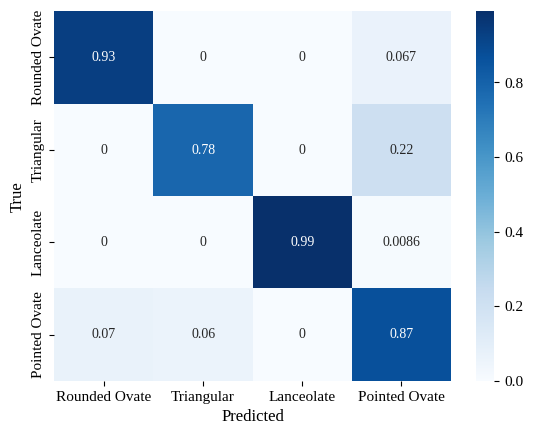

In [22]:
plt.rc('xtick', labelsize=11)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=11) 


cm = confusion_matrix(real_acc, pred_acc, normalize = 'true')
cm = pd.DataFrame(cm , columns = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'],index = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'])
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

0.5274333953857422

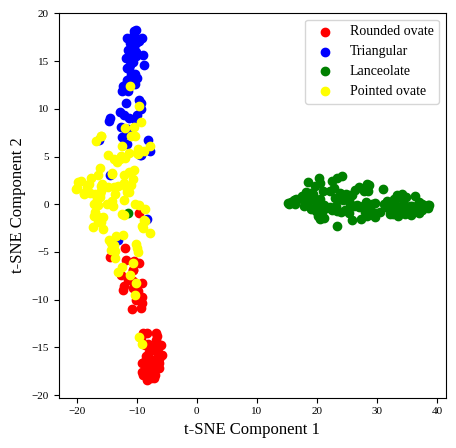

In [23]:

plt.figure(figsize=(5, 5))

plt.rc('xtick', labelsize=8)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=8)  # y축 눈금 폰트 크기
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10) 

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings.detach().cpu())

df_tsne = pd.DataFrame(data = X_tsne)
df_tsne['label']= real_acc
df_tsne

plt.scatter(df_tsne[df_tsne['label'] == 0][0], df_tsne[df_tsne['label'] == 0][1], label = 'Rounded ovate',  c= 'red')
plt.scatter(df_tsne[df_tsne['label'] == 1][0], df_tsne[df_tsne['label'] == 1][1], label = 'Triangular', c= 'blue')
plt.scatter(df_tsne[df_tsne['label'] == 2][0], df_tsne[df_tsne['label'] == 2][1], label = 'Lanceolate', c= 'green')
plt.scatter(df_tsne[df_tsne['label'] == 3][0], df_tsne[df_tsne['label'] == 3][1], label = 'Pointed ovate',  c= 'yellow')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

score = silhouette_score(X_tsne, real_acc)
score

In [24]:
score_samples = silhouette_samples(df_tsne[[0, 1]], df_tsne['label'])
df_tsne['sil_coeffi'] = score_samples
df_tsne.groupby('label')['sil_coeffi'].mean()

label
0    0.558175
1    0.463189
2    0.768414
3    0.267997
Name: sil_coeffi, dtype: float32

In [ ]:
# label
# 0    0.509735
# 1    0.379899
# 2    0.768183
# 3    0.120556